$\LaTeX$ definitions:
$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{\dd #1}{\dd #2}}
$$

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [23]:
from astropy.cosmology import Planck15
import astropy.units as u
import corner
import pystan
import seaborn as sns

In [13]:
sns.set_style('ticks')
sns.set_context('notebook')
sns.set_palette('colorblind')

This is a very simple cosmology fitter using Stan's ODE solver function to compute luminosity distances and fit for a single density parameter and H0 (we assume a flat universe composed only of matter and dark energy, so $\Omega_m + \Omega_\Lambda = 1$).

The luminosity distance is given by 
$$
D_L(z) = \frac{c (1+z)}{H_0} \int_0^{z} \dd z \, \frac{1}{\sqrt{\Omega_M (1+z)^3 + \Omega_\Lambda}} = \frac{c (1+z)}{H_0} I(z),
$$
where 
$$
\diff{I}{z} = \frac{1}{\sqrt{\Omega_M (1+z)^3 + \Omega_\Lambda}},
$$
and 
$$
I(0) = 0.
$$

First, we generate some mock data:

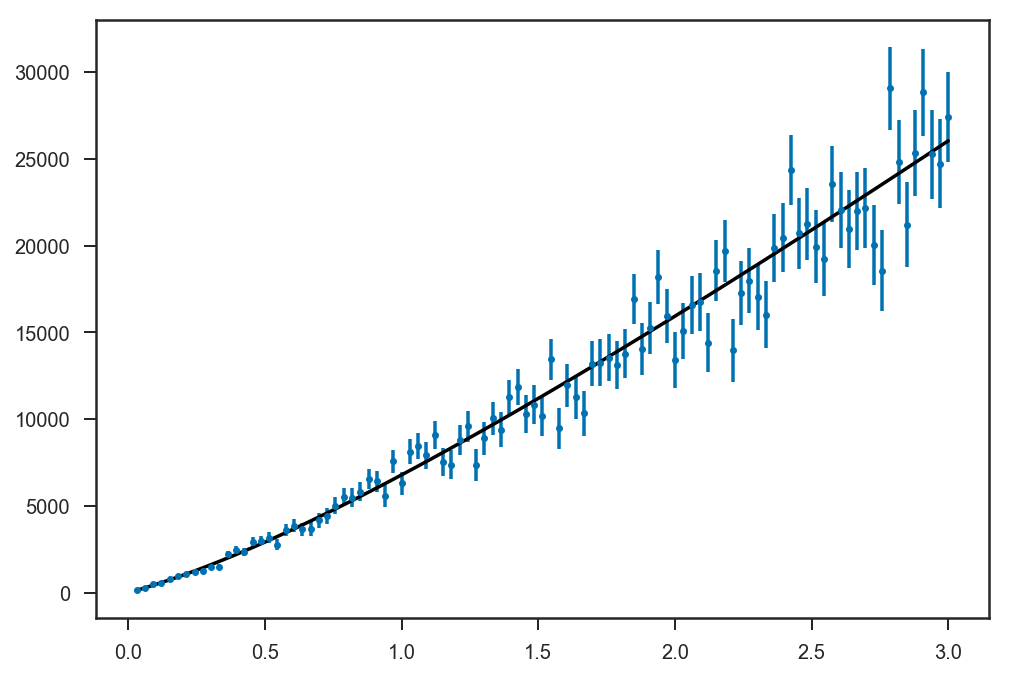

In [43]:
zs = linspace(0, 3, 100)
zs = zs[1:] # We don't want z = 0
dls_true = Planck15.luminosity_distance(zs).to(u.Mpc).value
sigma_dls = 0.1*dls_true
dls_obs = dls_true + sigma_dls*randn(dls_true.shape[0])

errorbar(zs, dls_obs, sigma_dls, fmt='.')
plot(zs, dls_true, '-k')

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5685b44085743d4a77fc87d322115e51 NOW.


Inference for Stan model: anon_model_5685b44085743d4a77fc87d322115e51.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
H0            66.01    0.06   1.69  62.83  64.87  65.98  67.12  69.52    854    1.0
Omegas[0]      0.36  1.3e-3   0.04   0.28   0.33   0.36   0.38   0.44    905    1.0
Omegas[1]      0.64  1.3e-3   0.04   0.56   0.62   0.64   0.67   0.72    905    1.0
dls_pred[0]  140.73    0.12   3.48 133.76  138.4 140.71 143.06  147.5    853    1.0
dls_pred[1]  287.34    0.23   6.86 273.61 282.79 287.34 291.96 300.64    856    1.0
dls_pred[2]  439.62    0.35  10.14  419.3 432.91 439.62 446.46 459.39    859    1.0
dls_pred[3]  597.34    0.45  13.31 570.58 588.56 597.32 606.34 623.31    863    1.0
dls_pred[4]  760.28    0.56  16.36 727.47 749.56 760.38 771.39 792.06    868    1.0
dls_pred[5]  928.25    0.65  19.29 889.62 915.65 928.49

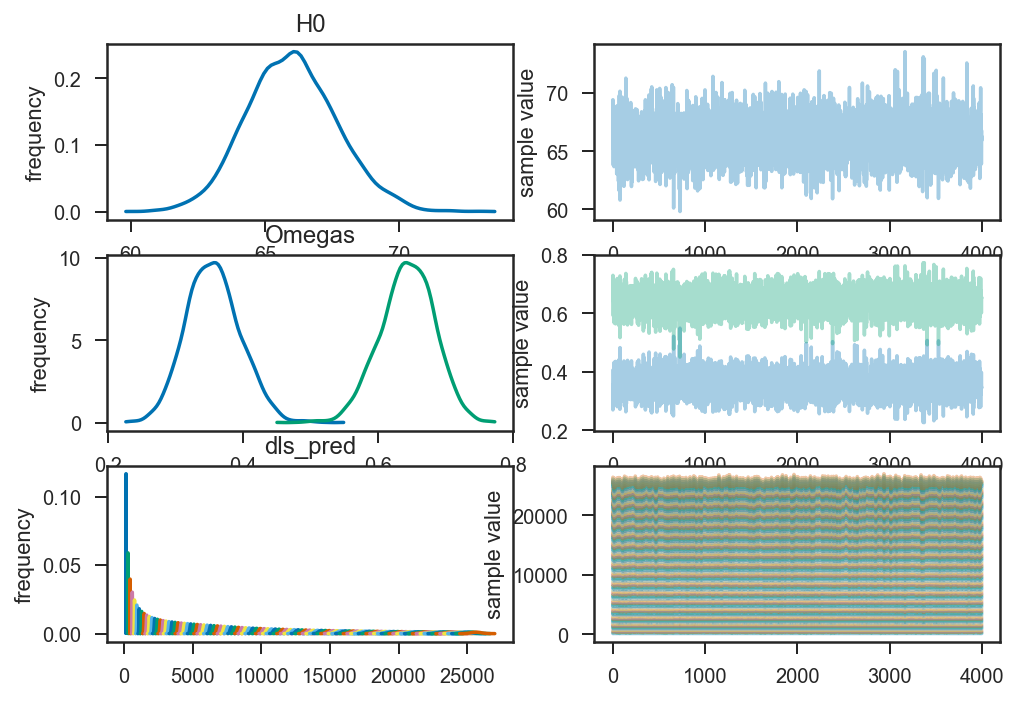

In [44]:
cosmography_data = {'Nobs': zs.shape[0],
                    'dls_obs': dls_obs,
                    'sigma_dls_obs': sigma_dls,
                    'zobs': zs}
thin = 1
fit = pystan.stan(file='cosmography.stan', data=cosmography_data, thin=thin, iter=2000*thin)
fit.plot()
fit

In [45]:
chains = fit.extract()

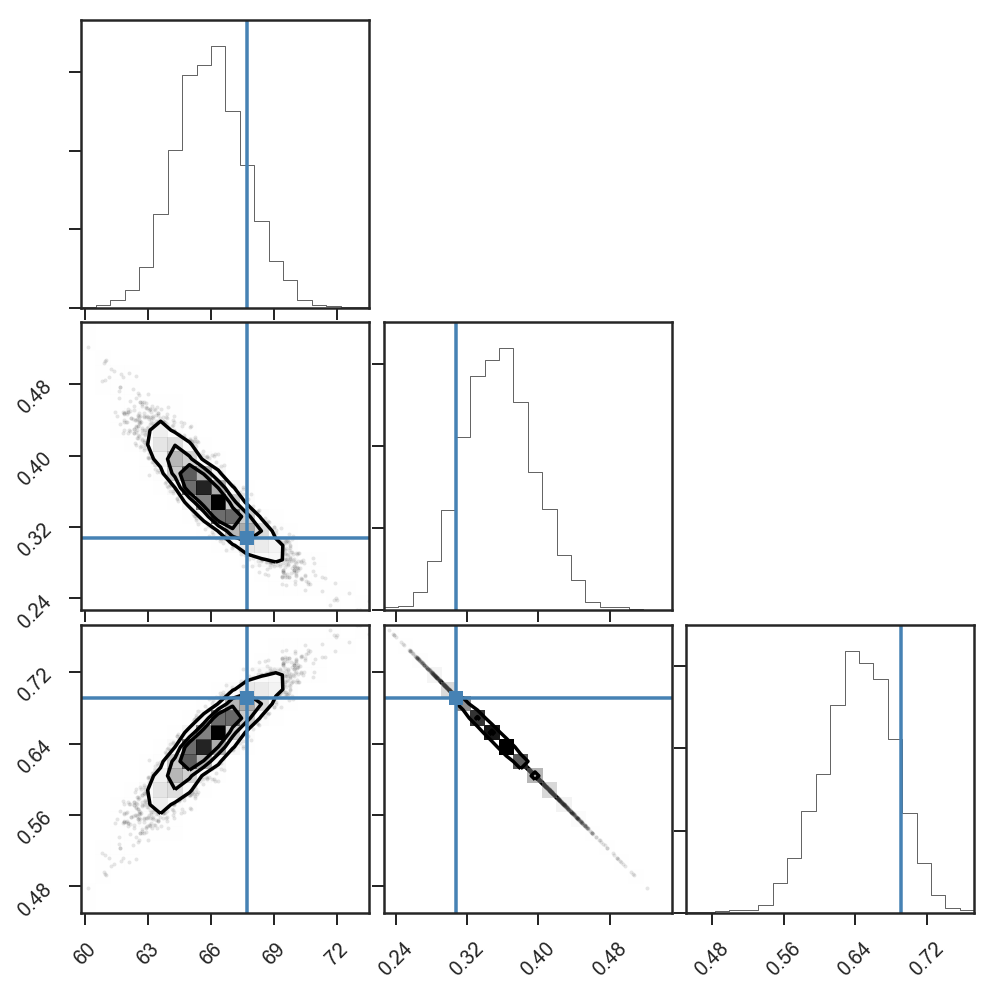

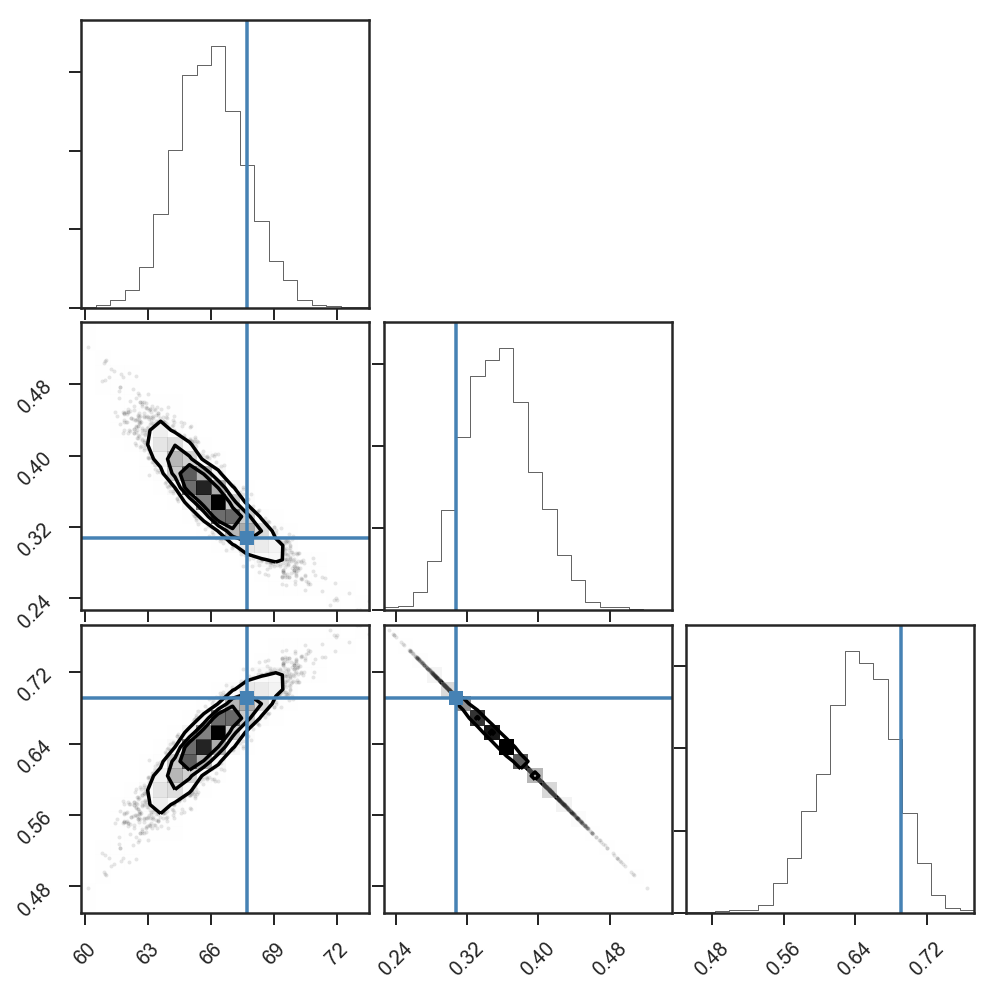

In [46]:
corner.corner(column_stack((chains['H0'], chains['Omegas'])), truths=[Planck15.H0.to(u.km/u.s/u.Mpc).value, Planck15.Om(0), Planck15.Ode(0)])

And, since we don't have any peculiar motion, or other measurement errors on the redshifts, we have really built a hierarchical, cosmological model of distance.  The plot below shows the data, the true redshift-distance relation, and the inferred distances of each object once we have fit the cosmology.  The posterior distance estimates have such tiny uncertainty because we do not have any uncertainty in the redshift, and we assume that the cosmological relation perfectly maps redshift to distance; the only remaining source of uncertainty comes from the cosmological parameters, and that is tiny.

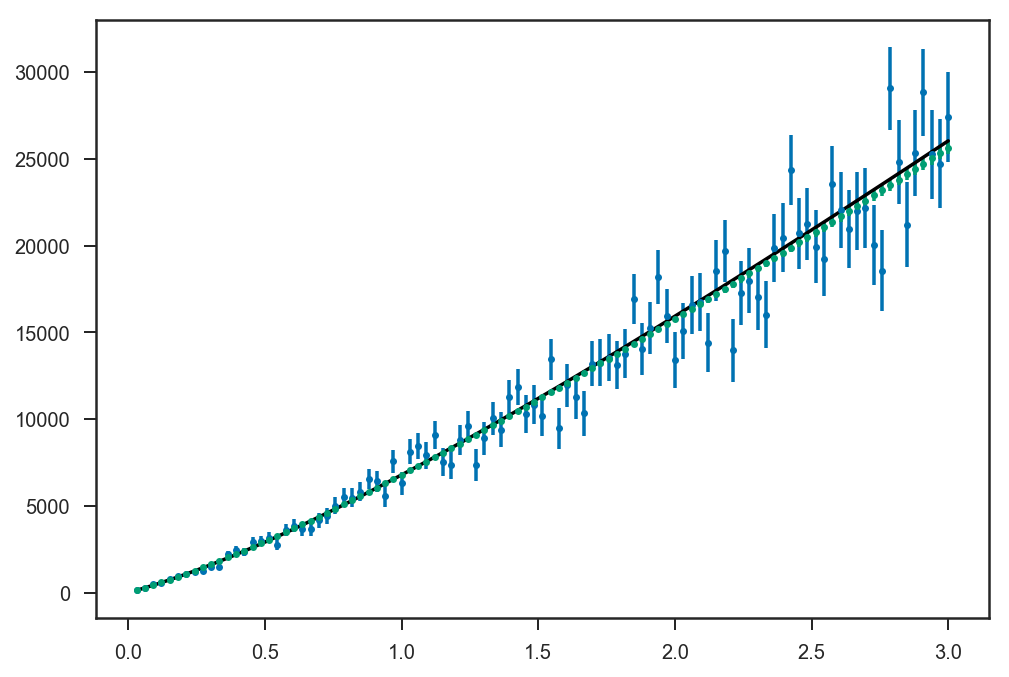

In [48]:
errorbar(zs, dls_obs, sigma_dls, fmt='.', label='Data')
errorbar(zs, mean(chains['dls_pred'], axis=0), std(chains['dls_pred'], axis=0), fmt='.', label='Predicted')
plot(zs, dls_true, '-k')